<a href="https://colab.research.google.com/github/nrajmalwar/Image-Classification-for-Food-101-Dataset/blob/master/Food_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Important Libraries

In [0]:
# Load Important Libraries

import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from scipy.misc import imresize

%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.models import load_model

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
import math
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from imgaug import augmenters as iaa
from sklearn import metrics

#Load Dataset

In [0]:
# Downloading the dataset from the website

!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

--2019-04-26 10:15:16--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2019-04-26 10:15:17--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  5.42MB/s    in 26m 3s  

2019-04-26 10:41:20 (3.05 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [0]:
#Unzipping the dataset into Colab Disk Storage

!tar xzvf food-101.tar.gz

food-101/
food-101/images/
food-101/images/beignets/
food-101/images/beignets/2885220.jpg
food-101/images/beignets/1814040.jpg
food-101/images/beignets/81202.jpg
food-101/images/beignets/1827892.jpg
food-101/images/beignets/2802124.jpg
food-101/images/beignets/2192983.jpg
food-101/images/beignets/250043.jpg
food-101/images/beignets/2786548.jpg
food-101/images/beignets/445116.jpg
food-101/images/beignets/3661460.jpg
food-101/images/beignets/1064858.jpg
food-101/images/beignets/2993714.jpg
food-101/images/beignets/2936669.jpg
food-101/images/beignets/1062952.jpg
food-101/images/beignets/2869806.jpg
food-101/images/beignets/178659.jpg
food-101/images/beignets/1261083.jpg
food-101/images/beignets/1296128.jpg
food-101/images/beignets/3157161.jpg
food-101/images/beignets/646871.jpg
food-101/images/beignets/3438314.jpg
food-101/images/beignets/3019700.jpg
food-101/images/beignets/1133765.jpg
food-101/images/beignets/1199143.jpg
food-101/images/beignets/287665.jpg
food-101/images/beignets/3452

In [0]:
!ls


food-101	 sample_data	    tiny-imagenet-200.zip
food-101.tar.gz  tiny-imagenet-200


#Split Dataset

In [0]:
# Splitting the dataset into train and test folder

class_to_ix = {}
ix_to_class = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

In [0]:
# Splitting the dataset into train and test folder

if not os.path.isdir('./food-101/test') and not os.path.isdir('./food-101/train'):

    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass 
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)

    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + '.jpg')
        return dir_files

    train_dir_files = generate_dir_file_map('food-101/meta/train.txt')
    test_dir_files = generate_dir_file_map('food-101/meta/test.txt')


    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree('food-101/images', 'food-101/test', ignore=ignore_train)
    copytree('food-101/images', 'food-101/train', ignore=ignore_test)
    
else:
    print('Train/Test files already copied into separate folders.')

food-101/images
food-101/images/chicken_wings
food-101/images/pancakes
food-101/images/waffles
food-101/images/caprese_salad
food-101/images/chicken_quesadilla
food-101/images/poutine
food-101/images/gnocchi
food-101/images/pizza
food-101/images/hot_dog
food-101/images/ramen
food-101/images/hamburger
food-101/images/beignets
food-101/images/chicken_curry
food-101/images/guacamole
food-101/images/oysters
food-101/images/mussels
food-101/images/spring_rolls
food-101/images/paella
food-101/images/lobster_bisque
food-101/images/peking_duck
food-101/images/bruschetta
food-101/images/dumplings
food-101/images/creme_brulee
food-101/images/prime_rib
food-101/images/french_toast
food-101/images/ceviche
food-101/images/sashimi
food-101/images/hummus
food-101/images/huevos_rancheros
food-101/images/macaroni_and_cheese
food-101/images/cannoli
food-101/images/garlic_bread
food-101/images/red_velvet_cake
food-101/images/hot_and_sour_soup
food-101/images/strawberry_shortcake
food-101/images/pad_thai


In [0]:
!ls

food-101	 sample_data	    tiny-imagenet-200.zip
food-101.tar.gz  tiny-imagenet-200


#Plotting Random Images

In [0]:
#Creating a generator object so that we don't load all the images at once

train_datagen = ImageDataGenerator(rescale= 1./255)

train_generator = train_datagen.flow_from_directory( r'./food-101/train/', color_mode='rgb', target_size = (299,299),
                                                    batch_size=64, class_mode='categorical', shuffle=True, seed=42)
true_classes = train_generator.classes
class_labels = list(train_generator.class_indices.keys())

valid_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = valid_datagen.flow_from_directory( r'./food-101/test/', color_mode='rgb', target_size=(299,299),
                                                    batch_size=64, class_mode='categorical', shuffle=True, seed=42)

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


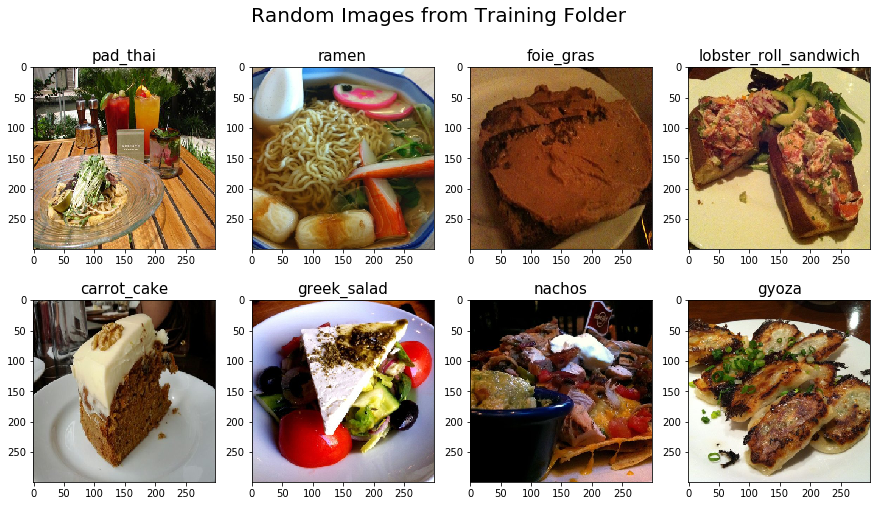

In [0]:
# Plotting random images from the training folder

x_batch, y_batch = next(train_generator)

fig = plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace = -0.6)
fig.suptitle('Random Images from Training Folder', fontsize=20, y =0.75)
fig.tight_layout()

for i in range(8):
    
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(x_batch[i,:,:], interpolation='None')
    j = np.argmax(y_batch[i])
    
    sub.set_title(class_labels[j], fontsize = 15)

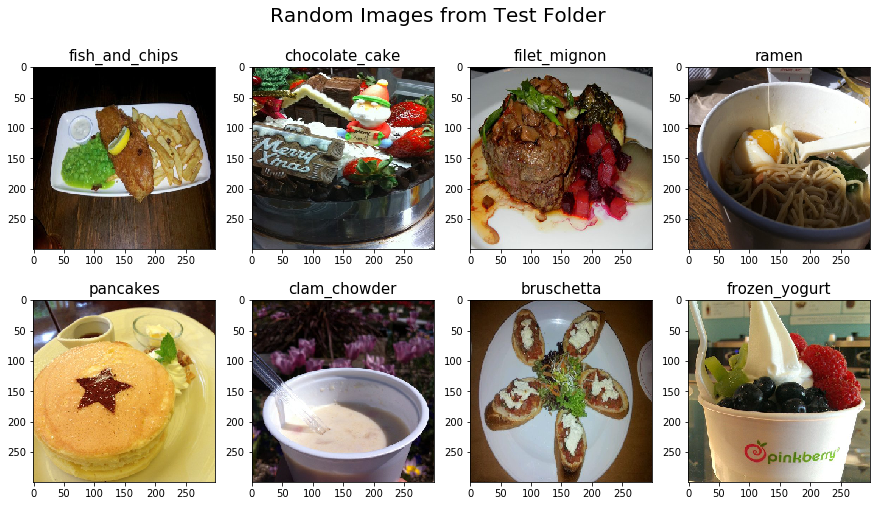

In [0]:
# Plotting random images from the test folder

x_batch, y_batch = next(validation_generator)

fig = plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace = -0.6)
fig.suptitle('Random Images from Test Folder', fontsize=20, y =0.75)
fig.tight_layout()

for i in range(8):
    
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(x_batch[i,:,:], interpolation='None')
    j = np.argmax(y_batch[i])
    
    sub.set_title(class_labels[j], fontsize = 15)

#Image Augmentation

In [0]:
# Use image augmentation from the keras Image Preprocessing library

train_datagen = ImageDataGenerator(rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   brightness_range=None, 
                                   shear_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True,                                   
                                   rescale= 1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory( r'./food-101/train/', color_mode='rgb', target_size = (299,299),
                                                    batch_size=64, class_mode='categorical', shuffle=True, seed=42)

validation_generator = valid_datagen.flow_from_directory( r'./food-101/test/', color_mode='rgb', target_size=(299,299),
                                                    batch_size=64, class_mode='categorical', shuffle=True, seed=42)

train_steps = np.math.ceil(train_generator.samples / train_generator.batch_size)
validation_steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size)

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


In [0]:
# Mount Google drive to save the models after training

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#Training

In [0]:
K.clear_session()

# Train the model with InceptionV3 using pretrained weights for the imagenet dataset
# We tried running the model with InceptionV3, ResNet 50, DenseNet101, Xception with pretrained weights from the imagenet dataset
# InceptionV3 was best among the models 
# Xception model was the second best which reached an accuracy of 82% but had a batch size of 32 images maximum, so it was slower to train

base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))

# Make the base model non trainable to use the pretrained weights and save computation time

base_model.trainable = False
x = base_model.output

n_classes = 101

# We add a 1x1 convolution to convert the last layer into required number of channels = number of classes

x = Conv2D(n_classes, (1,1), name='conv_x', use_bias=False)(x)
x = BatchNormalization(name='norm_x')(x)

# GlobalAveragePooling2D to give a single output from each channel and flatten

x = GlobalAveragePooling2D(data_format=None)(x)
predictions = Activation('softmax')(x)

model = Model(input=base_model.input, output=predictions)

# Using SGD with low learning rate and high momentum

opt = SGD(lr=.001, momentum=.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Using lr_reducer to decrease the value of learning when the model hits a plateau for 5 epochs

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

# Using a checkpointer to save the model with best accuracy

checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/Food_1.hdf5', monitor='val_acc', verbose=1, save_best_only=True)

model.fit_generator(train_generator,steps_per_epoch=200,
                    validation_data=validation_generator, validation_steps=200, 
                    epochs=20,  verbose=1, 
                    callbacks=[checkpointer, lr_reducer])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


Epoch 1/20
200/200 [==============================] - 472s 2s/step - loss: 4.2040 - acc: 0.1471 - val_loss: 3.4733 - val_acc: 0.3237

Epoch 00001: val_acc improved from -inf to 0.32367, saving model to /content/drive/My Drive/Colab Notebooks/Food_1.hdf5
Epoch 2/20
200/200 [==============================] - 443s 2s/step - loss: 3.4023 - acc: 0.3667 - val_loss: 2.7286 - val_acc: 0.4860

Epoch 00002: val_acc improved from 0.32367 to 0.48598, saving model to /content/drive/My Drive/Colab Notebooks/Food_1.hdf5
Epoch 3/20
200/200 [==============================] - 446s 2s/step - loss: 2.9668 - acc: 0.4521 - val_loss: 2.3302 - val_acc: 0.5586

Epoch 00003: val_acc improved from 0.48598 to 0.55859, saving model to /content/drive/My Drive/Colab Notebooks/Food_1.hdf5
Epoch 4/20
200/200 [==============================] - 445s 2s/step - loss: 2.6819 - acc: 0.4884 - val_loss: 2.0524 - val_acc: 0.5869

Epoch 00004: val_acc improved from 0.55859 to 0.58692, saving model to /content/drive/My Drive/Col

In [0]:
model = load_model('/content/drive/My Drive/Colab Notebooks/Food_1.hdf5')


model.fit_generator(train_generator,steps_per_epoch=200,
                    validation_data=validation_generator, validation_steps=200, 
                    epochs=20,  verbose=1, 
                    callbacks=[checkpointer, lr_reducer])

Epoch 1/20
200/200 [==============================] - 448s 2s/step - loss: 1.2769 - acc: 0.7044 - val_loss: 0.8768 - val_acc: 0.7826

Epoch 00001: val_acc improved from 0.78034 to 0.78258, saving model to /content/drive/My Drive/Colab Notebooks/Food_1.hdf5
Epoch 2/20
200/200 [==============================] - 429s 2s/step - loss: 1.2568 - acc: 0.7102 - val_loss: 0.8461 - val_acc: 0.7895

Epoch 00002: val_acc improved from 0.78258 to 0.78951, saving model to /content/drive/My Drive/Colab Notebooks/Food_1.hdf5
Epoch 3/20
200/200 [==============================] - 431s 2s/step - loss: 1.2286 - acc: 0.7163 - val_loss: 0.8413 - val_acc: 0.7916

Epoch 00003: val_acc improved from 0.78951 to 0.79156, saving model to /content/drive/My Drive/Colab Notebooks/Food_1.hdf5
Epoch 4/20
200/200 [==============================] - 430s 2s/step - loss: 1.1865 - acc: 0.7200 - val_loss: 0.8550 - val_acc: 0.7850

Epoch 00004: val_acc did not improve from 0.79156
Epoch 5/20
200/200 [=========================

In [0]:
model = load_model('/content/drive/My Drive/Colab Notebooks/Food_1.hdf5')


model.fit_generator(train_generator,steps_per_epoch=200,
                    validation_data=validation_generator, validation_steps=200, 
                    epochs=10,  verbose=1, 
                    callbacks=[checkpointer, lr_reducer])

Epoch 1/10
200/200 [==============================] - 470s 2s/step - loss: 0.8991 - acc: 0.7846 - val_loss: 0.7202 - val_acc: 0.8184

Epoch 00001: val_acc did not improve from 0.82263
Epoch 2/10
200/200 [==============================] - 433s 2s/step - loss: 0.8790 - acc: 0.7914 - val_loss: 0.7043 - val_acc: 0.8206

Epoch 00002: val_acc did not improve from 0.82263
Epoch 3/10
200/200 [==============================] - 432s 2s/step - loss: 0.8846 - acc: 0.7849 - val_loss: 0.7494 - val_acc: 0.8129

Epoch 00003: val_acc did not improve from 0.82263
Epoch 4/10
200/200 [==============================] - 438s 2s/step - loss: 0.9022 - acc: 0.7831 - val_loss: 0.6875 - val_acc: 0.8251

Epoch 00004: val_acc improved from 0.82263 to 0.82506, saving model to /content/drive/My Drive/Colab Notebooks/Food_1.hdf5
Epoch 5/10
200/200 [==============================] - 444s 2s/step - loss: 0.8696 - acc: 0.7890 - val_loss: 0.7090 - val_acc: 0.8182

Epoch 00005: val_acc did not improve from 0.82506
Epoch 6

#Heavy Augmentations

In [0]:
# After hitting saturation for around 82% val acc, we use heavy augmentations from the imgaug library to train the model better

seq = iaa.OneOf([iaa.Affine(scale=(0.5, 1.5)),
                 iaa.CoarseDropout((0.0, 0.2), size_percent=(0.05, 0.07)),
                 iaa.AdditiveGaussianNoise(scale=0.2*255),
                 iaa.CropAndPad(percent=(-0.25, 0.25)),
                 iaa.GaussianBlur(sigma=3.0),
                 iaa.ContrastNormalization((0.5, 1.5))
     ])

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, rescale=1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory( r'./food-101/train/', color_mode='rgb', target_size = (299,299),
                                                    batch_size=64, class_mode='categorical', shuffle=True, seed=42)

validation_generator = valid_datagen.flow_from_directory( r'./food-101/test/', color_mode='rgb', target_size=(299,299),
                                                    batch_size=64, class_mode='categorical', shuffle=True, seed=42)

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


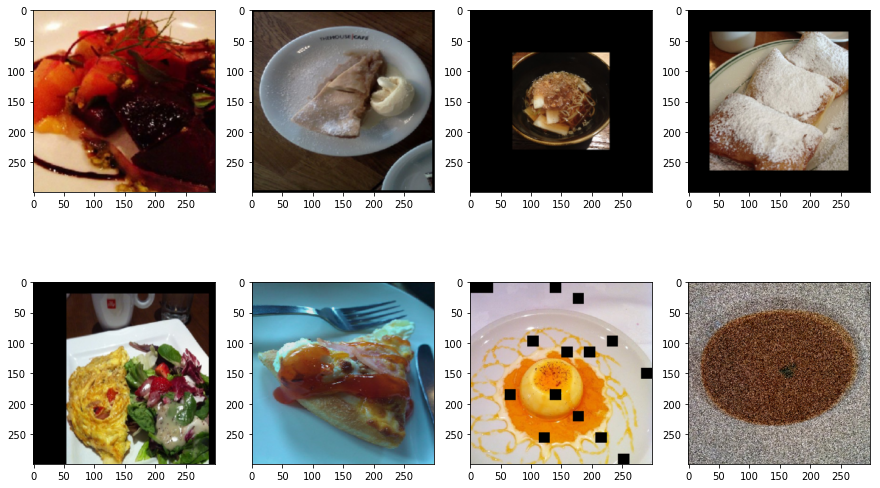

In [0]:
# Samples of image augmentationsx_batch, y_batch = next(train_generator)

fig = plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=-0.5)
for i in range(8):
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(x_batch[i,:,:], interpolation='bilinear')

In [0]:
model = load_model('/content/drive/My Drive/Colab Notebooks/Food_1.hdf5')

checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/Food_2.hdf5', monitor='val_acc', verbose=1, save_best_only=True)

model.fit_generator(train_generator,steps_per_epoch=200,
                    validation_data=validation_generator, validation_steps=200, 
                    epochs=20,  verbose=1, 
                    callbacks=[checkpointer, lr_reducer])

Epoch 1/20
200/200 [==============================] - 310s 2s/step - loss: 1.1865 - acc: 0.7053 - val_loss: 0.7517 - val_acc: 0.8107

Epoch 00001: val_acc improved from -inf to 0.81070, saving model to /content/drive/My Drive/Colab Notebooks/Food_2.hdf5
Epoch 2/20
200/200 [==============================] - 297s 1s/step - loss: 1.0660 - acc: 0.7377 - val_loss: 0.7254 - val_acc: 0.8175

Epoch 00002: val_acc improved from 0.81070 to 0.81754, saving model to /content/drive/My Drive/Colab Notebooks/Food_2.hdf5
Epoch 3/20
200/200 [==============================] - 293s 1s/step - loss: 1.0352 - acc: 0.7446 - val_loss: 0.6976 - val_acc: 0.8213

Epoch 00003: val_acc improved from 0.81754 to 0.82133, saving model to /content/drive/My Drive/Colab Notebooks/Food_2.hdf5
Epoch 4/20
200/200 [==============================] - 297s 1s/step - loss: 1.0157 - acc: 0.7481 - val_loss: 0.6776 - val_acc: 0.8252

Epoch 00004: val_acc improved from 0.82133 to 0.82522, saving model to /content/drive/My Drive/Col

In [0]:
model = load_model('/content/drive/My Drive/Colab Notebooks/Food_2.hdf5')

checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/Food_2.hdf5', monitor='val_acc', verbose=1, save_best_only=True)

model.fit_generator(train_generator,steps_per_epoch=200,
                    validation_data=validation_generator, validation_steps=200, 
                    epochs=20,  verbose=1, 
                    callbacks=[checkpointer, lr_reducer])

Epoch 1/20
200/200 [==============================] - 314s 2s/step - loss: 0.7133 - acc: 0.8233 - val_loss: 0.6211 - val_acc: 0.8425

Epoch 00001: val_acc improved from -inf to 0.84250, saving model to /content/drive/My Drive/Colab Notebooks/Food_2.hdf5
Epoch 2/20
200/200 [==============================] - 292s 1s/step - loss: 0.7311 - acc: 0.8178 - val_loss: 0.6475 - val_acc: 0.8365

Epoch 00002: val_acc did not improve from 0.84250
Epoch 3/20
200/200 [==============================] - 294s 1s/step - loss: 0.7282 - acc: 0.8205 - val_loss: 0.6452 - val_acc: 0.8356

Epoch 00003: val_acc did not improve from 0.84250
Epoch 4/20
200/200 [==============================] - 292s 1s/step - loss: 0.6988 - acc: 0.8268 - val_loss: 0.6254 - val_acc: 0.8402

Epoch 00004: val_acc did not improve from 0.84250
Epoch 5/20
200/200 [==============================] - 291s 1s/step - loss: 0.6865 - acc: 0.8264 - val_loss: 0.6633 - val_acc: 0.8336

Epoch 00005: val_acc did not improve from 0.84250
Epoch 6/20

#Model Evaluation

In [0]:
valid_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = valid_datagen.flow_from_directory( r'./food-101/test/', color_mode='rgb', target_size=(299,299),
                                                    batch_size=64, class_mode='categorical', shuffle=True, seed=42)

In [0]:
# Evaluating the model on the test dataset

model = load_model('/content/drive/My Drive/Colab Notebooks/Food_2.hdf5')

validation_steps_per_epoch = np.math.ceil(validation_generator.samples / validation_generator.batch_size)

score = model.evaluate_generator(validation_generator, verbose=1, steps=validation_steps_per_epoch)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
395/395 [==============================] - 195s 494ms/step
Test loss: 0.556899811724625
Test accuracy: 0.8584554455539968


#Results

In [0]:
model = load_model('/content/drive/My Drive/Colab Notebooks/Food_2.hdf5')

In [0]:
#Running the model on test dataset saving the predictions 

validation_generator = valid_datagen.flow_from_directory( r'./food-101/test/', color_mode='rgb', target_size=(299,299),
                                                    batch_size=64, class_mode='categorical', shuffle=False, seed=42)

validation_steps_per_epoch = np.math.ceil(validation_generator.samples / validation_generator.batch_size)

predictions = model.predict_generator(validation_generator, steps=validation_steps_per_epoch)

predicted_classes = np.argmax(predictions, axis=-1)

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

Found 25250 images belonging to 101 classes.


In [0]:
# Saving the correctly and incorrectly classified images information in a dictionary

j = 0

corrects = collections.defaultdict(int)
incorrects = collections.defaultdict(int)

for x_batch, y_batch in validation_generator:
  if j == 25250:
    break
  for i in range(len(x_batch)):
    if predicted_classes[j]== true_classes[j]:
      corrects[predicted_classes[j]] += 1
      
    else:
        incorrects[true_classes[j]] += 1
    j += 1
    
class_accuracies = {}
for i in range(101):
    class_accuracies[i] = corrects[i]/250
sorted_class_accuracies = sorted(class_accuracies.items(), key=lambda x: -x[1])
print(sorted_class_accuracies)

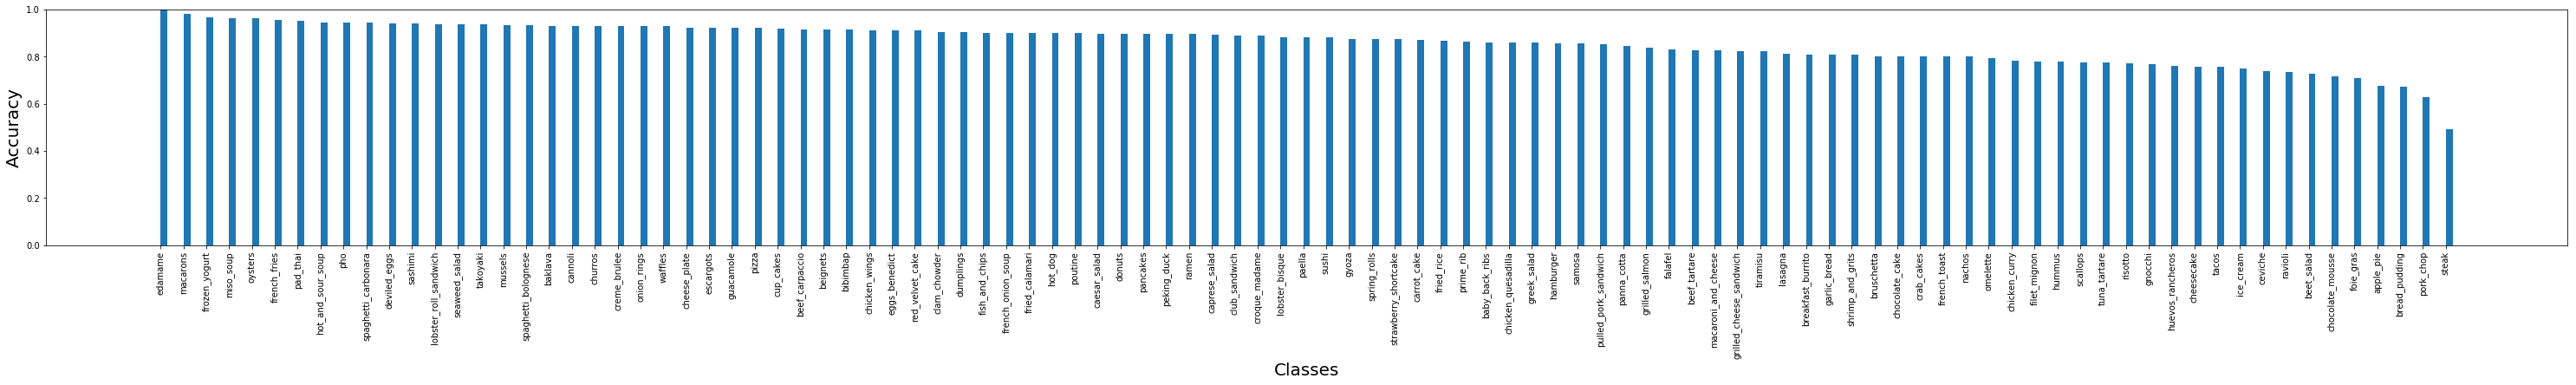

In [0]:
# Plotting the Accuracy vs Class

labels, ys = zip(*sorted_class_accuracies)
xs = np.arange(len(labels)) 

labels_2 = []
for i in labels:
  labels_2.append(class_labels[i])
    
width = 0.3
f, ax = plt.subplots(figsize=(101,5))
ax.bar(xs, ys, width, align='edge')
plt.subplots_adjust(left=0.5)
plt.xticks(xs, labels_2, rotation='vertical') 

plt.ylim([0,1])
plt.xlabel("Classes", fontsize= 20)
plt.ylabel("Accuracy", fontsize = 20)
plt.show()

In [0]:
# Confusion matrix 

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                         precision    recall  f1-score   support

              apple_pie       0.72      0.68      0.70       250
         baby_back_ribs       0.83      0.86      0.85       250
                baklava       0.86      0.93      0.89       250
         beef_carpaccio       0.91      0.92      0.91       250
           beef_tartare       0.85      0.83      0.84       250
             beet_salad       0.81      0.73      0.77       250
               beignets       0.92      0.92      0.92       250
               bibimbap       0.95      0.92      0.93       250
          bread_pudding       0.73      0.67      0.70       250
      breakfast_burrito       0.83      0.81      0.82       250
             bruschetta       0.85      0.80      0.82       250
           caesar_salad       0.84      0.90      0.87       250
                cannoli       0.92      0.93      0.92       250
          caprese_salad       0.82      0.89      0.86       250
            carrot_cake 